In [8]:
import folium
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import openpyxl


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

import geopandas as gpd
from shapely.geometry import Point  # Importa la clase Point para crear geometrías de puntos

In [9]:

df_estimaciones = pd.read_csv('estimaciones-agricolas-2020-08.csv', sep=',', encoding='latin-1')



In [10]:
df_estimaciones

,id_provincia,provincia,id_departamento,departamento,id_cultivo,cultivo,id_campaña,campaña,sup_sembrada,sup_cosechada,produccion,rendimiento
0,6,Buenos Aires,854,25 de Mayo,1,Ajo,1,1969/1970,3,3,10,3333
1,6,Buenos Aires,854,25 de Mayo,1,Ajo,2,1970/1971,1,1,3,3000
2,6,Buenos Aires,14,Adolfo Gonzales Chaves,1,Ajo,1,1969/1970,15,15,82,5467
3,6,Buenos Aires,14,Adolfo Gonzales Chaves,1,Ajo,2,1970/1971,10,10,55,5500
4,6,Buenos Aires,14,Adolfo Gonzales Chaves,1,Ajo,3,1971/1972,8,8,44,5500
...,...,...,...,...,...,...,...,...,...,...,...,...
143625,54,Misiones,112,San Pedro,31,Yerba mate,46,2014/2015,7975,7905,43478,5500
143626,54,Misiones,112,San Pedro,31,Yerba mate,47,2015/2016,7975,7905,46640,5900
143627,54,Misiones,112,San Pedro,31,Yerba mate,48,2016/2017,8200,8200,33620,4100
143628,54,Misiones,112,San Pedro,31,Yerba mate,49,2017/2018,8787,8787,43054,4900


In [11]:
df_estimaciones.describe()

,id_provincia,id_departamento,id_cultivo,id_campaña,sup_sembrada,sup_cosechada,produccion,rendimiento
count,143630.000000,143630.000000,143630.000000,143630.000000,1.436300e+05,1.436300e+05,1.436300e+05,143630.000000
mean,34.087029,190.445471,19.295899,22.188596,1.162731e+04,1.013002e+04,3.110532e+04,3533.567235
std,29.300535,228.202917,10.161226,14.897955,3.462306e+04,3.318605e+04,1.228428e+05,5746.583592
min,6.000000,0.000000,1.000000,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,6.000000,49.000000,11.000000,9.000000,1.500000e+02,5.000000e+01,1.600000e+02,1000.000000
50%,22.000000,98.000000,21.000000,19.000000,1.250000e+03,7.000000e+02,1.600000e+03,1892.000000
75%,54.000000,189.000000,28.000000,35.000000,8.000000e+03,5.500000e+03,1.261675e+04,3512.000000
max,94.000000,882.000000,35.000000,51.000000,1.096100e+06,1.066100e+06,8.620000e+06,300000.000000


In [16]:
df_estimaciones.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143630 entries, 0 to 143629
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   id_provincia     143630 non-null  int64         
 1   provincia        143630 non-null  object        
 2   id_departamento  143630 non-null  int64         
 3   departamento     143630 non-null  object        
 4   id_cultivo       143630 non-null  int64         
 5   cultivo          143630 non-null  object        
 6   id_campaña       143630 non-null  int64         
 7   campaña          143630 non-null  object        
 8   sup_sembrada     143630 non-null  int64         
 9   sup_cosechada    143630 non-null  int64         
 10  produccion       143630 non-null  int64         
 11  rendimiento      143630 non-null  int64         
 12  año_inicio       143630 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(8), object(4)
memory usage: 14.2+ MB


In [12]:
df_estimaciones.columns

Index(['id_provincia', 'provincia', 'id_departamento', 'departamento',
       'id_cultivo', 'cultivo', 'id_campaña', 'campaña', 'sup_sembrada',
       'sup_cosechada', 'produccion ', 'rendimiento'],
      dtype='object')

# Análisis de Tendencias Agrícolas: Realiza un análisis exploratorio de datos para identificar tendencias en la producción agrícola a lo largo de diferentes años y regiones.

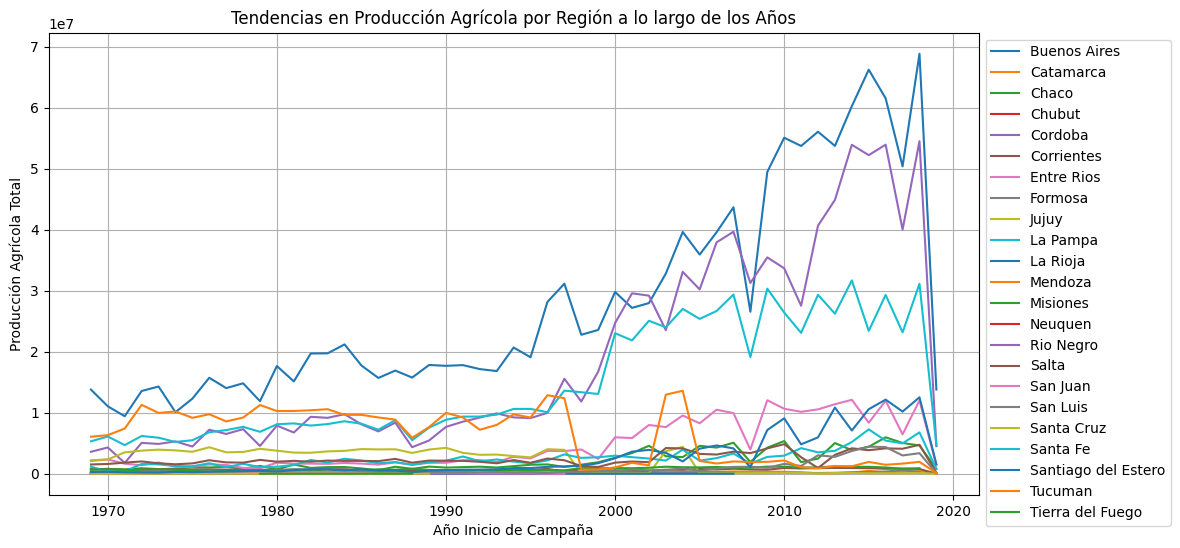

In [13]:


# usaremos una columna llamada 'año' para el año y 'provincia' para la región,
# y una columna 'campaña' que contiene dos años separados por '/' u otros delimitadores.

# Definir una función para extraer el año de inicio de campaña
def extraer_año_inicio(campaña):
    # Verificar si la cadena contiene el delimitador '/'
    if '/' in campaña:
        años = campaña.split('/')
        if len(años) == 2:
            return pd.to_datetime(años[0], format='%Y', errors='coerce')
    
    # Si no cumple con el formato, devuelve None
    return None

# Aplicar la función para obtener el año de inicio de campaña como objetos de fecha
df_estimaciones['año_inicio'] = df_estimaciones['campaña'].apply(extraer_año_inicio)

# Filtrar filas con años válidos y eliminar las que no cumplen el formato
df_estimaciones = df_estimaciones[df_estimaciones['año_inicio'].notnull()]

# Calcular la producción total por año y región
tendencias = df_estimaciones.groupby(['año_inicio', 'provincia'])['produccion '].sum().reset_index()

# Visualizar tendencias a lo largo de los años
plt.figure(figsize=(12, 6))
for provincia in tendencias['provincia'].unique():
    data = tendencias[tendencias['provincia'] == provincia]
    plt.plot(data['año_inicio'], data['produccion '], label=provincia)

plt.xlabel('Año Inicio de Campaña')
plt.ylabel('Producción Agrícola Total')
plt.title('Tendencias en Producción Agrícola por Región a lo largo de los Años')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()





#  Realiza una regresión lineal simple utilizando los datos de las columnas 'sup_cosechada' y 'produccion' del DataFrame df_estimaciones. El propósito principal de este código es estimar una relación lineal entre estas dos variables y visualizar los resultados.

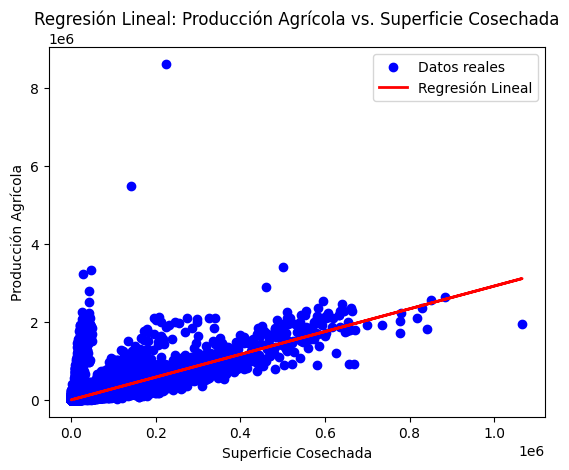

Coeficiente de la pendiente: 2.919197363036532
Intercepto: 1533.7875362112027


In [14]:

# Seleccionar la variable independiente (sup_cosechada) y la variable dependiente (produccion)
X = df_estimaciones['sup_cosechada'].values.reshape(-1, 1)
y = df_estimaciones['produccion '].values

# Crear un modelo de regresión lineal
modelo_regresion = LinearRegression()

# Ajustar el modelo a los datos
modelo_regresion.fit(X, y)

# Hacer predicciones
y_pred = modelo_regresion.predict(X)

# Visualizar los resultados
plt.scatter(X, y, color='blue', label='Datos reales')
plt.plot(X, y_pred, color='red', linewidth=2, label='Regresión Lineal')
plt.xlabel('Superficie Cosechada')
plt.ylabel('Producción Agrícola')
plt.title('Regresión Lineal: Producción Agrícola vs. Superficie Cosechada')
plt.legend()
plt.show()

# Imprimir los coeficientes de la regresión
print("Coeficiente de la pendiente:", modelo_regresion.coef_[0])
print("Intercepto:", modelo_regresion.intercept_)


# Se realiza un análisis de producción agrícola por Departamento y se visualizan aquellos con la mayor producción.

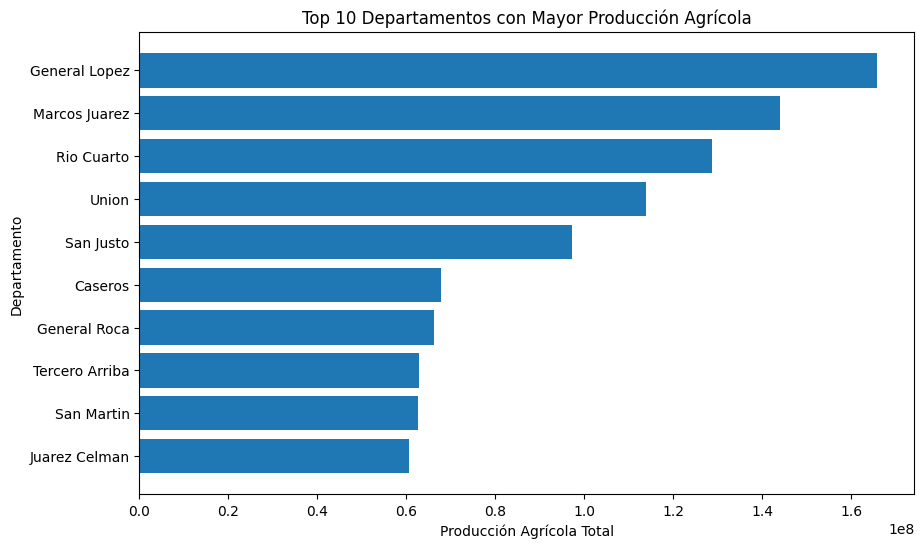

In [17]:


# Agrupa los datos por comuna y calcula la producción agrícola total para cada Departamento
produccion_por_departamento = df_estimaciones.groupby('departamento')['produccion '].sum().reset_index()

# Ordena las comunas por producción agrícola de mayor a menor
produccion_por_departamento = produccion_por_departamento.sort_values(by='produccion ', ascending=False)

# Visualiza las comunas con la mayor producción agrícola (por ejemplo, las 10 principales)
top_n_departamentos = 10
plt.figure(figsize=(10, 6))
plt.barh(produccion_por_departamento['departamento'].head(top_n_departamentos), produccion_por_departamento['produccion '].head(top_n_departamentos))
plt.xlabel('Producción Agrícola Total')
plt.ylabel('Departamento')
plt.title(f'Top {top_n_departamentos} Departamentos con Mayor Producción Agrícola')
plt.gca().invert_yaxis()  # Invierte el eje y para mostrar la comuna con la mayor producción en la parte superior
plt.show()


# Examinar la variación de rendimiento de cultivos en diferentes Provincias a lo largo de los años e identificar aquellos con un rendimiento constante o fluctuante

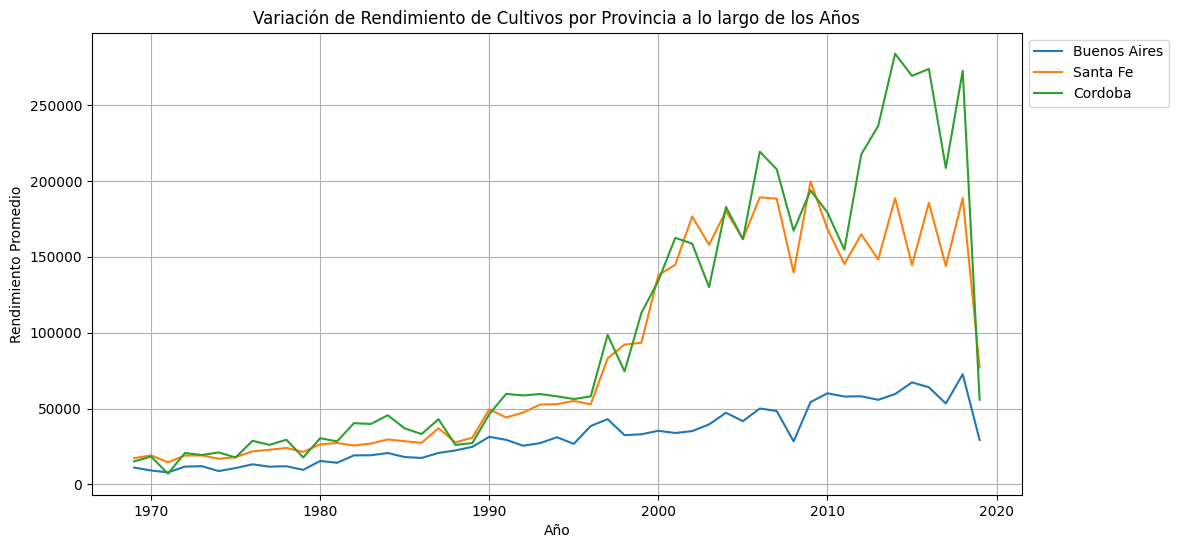

In [27]:
# Agrupa los datos por Provincia y año y calcula el rendimiento promedio
rendimiento_por_provincia = df_estimaciones.groupby(['provincia', 'año_inicio'])['produccion '].mean().reset_index()

# Visualiza la variación de rendimiento para algunos Provincia seleccionadas
provincia_seleccionadas = ['Buenos Aires', 'Santa Fe', 'Cordoba']  # Provincias que se quieren analizar
plt.figure(figsize=(12, 6))

for provincia in provincia_seleccionadas:
    data_provincia = rendimiento_por_provincia[rendimiento_por_provincia['provincia'] == provincia]
    plt.plot(data_provincia['año_inicio'], data_provincia['produccion '], label=provincia)

plt.xlabel('Año')
plt.ylabel('Rendimiento Promedio')
plt.title('Variación de Rendimiento de Cultivos por Provincia a lo largo de los Años')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()

# Examinar la variación de rendimiento de cultivos en diferentes Departamentos a lo largo de los años e identificar aquellos con un rendimiento constante o fluctuante

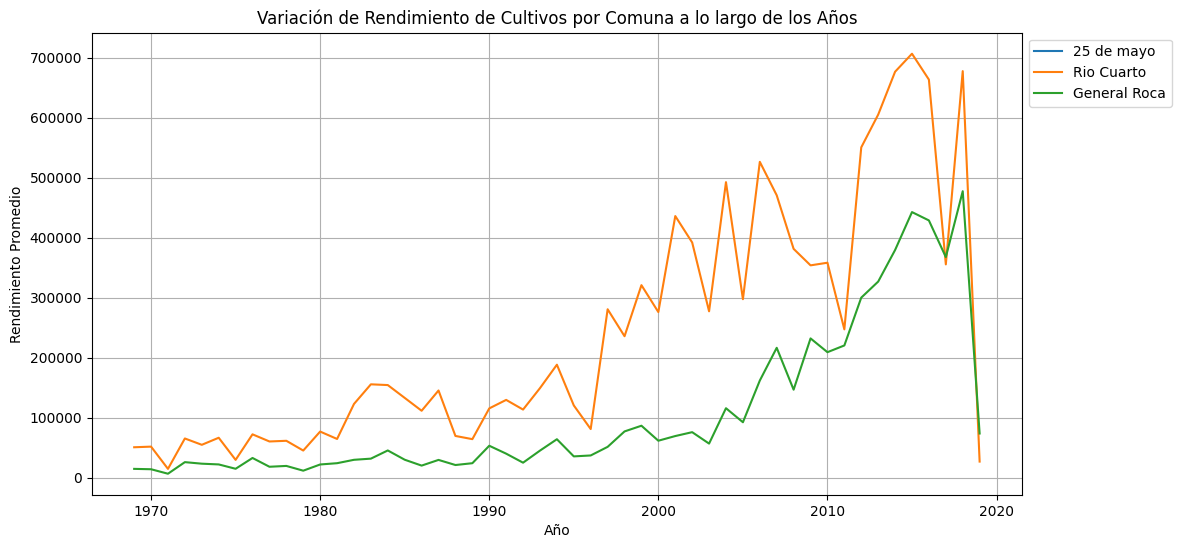

In [26]:


# Agrupa los datos por cdepartamento y año y calcula el rendimiento promedio
rendimiento_por_departamento = df_estimaciones.groupby(['departamento', 'año_inicio'])['produccion '].mean().reset_index()

# Visualiza la variación de rendimiento para algunos Departamentos seleccionadas
departamentos_seleccionados = ['25 de mayo', 'Rio Cuarto', 'General Roca']  # departamentos que se quieren analizar
plt.figure(figsize=(12, 6))

for departamento in departamentos_seleccionados:
    data_departamento = rendimiento_por_departamento[rendimiento_por_departamento['departamento'] == departamento]
    plt.plot(data_departamento['año_inicio'], data_departamento['produccion '], label=departamento)

plt.xlabel('Año')
plt.ylabel('Rendimiento Promedio')
plt.title('Variación de Rendimiento de Cultivos por Departamento a lo largo de los Años')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()


In [24]:
df_estimaciones['departamento']

0                     25 de Mayo
1                     25 de Mayo
2         Adolfo Gonzales Chaves
3         Adolfo Gonzales Chaves
4         Adolfo Gonzales Chaves
                   ...          
143625                 San Pedro
143626                 San Pedro
143627                 San Pedro
143628                 San Pedro
143629                 San Pedro
Name: departamento, Length: 143630, dtype: object